<h2>COVID-19 growth modeling and forecasting in Pakistan provinces with python</h2>
<p>Logistic Growth is a mathematical function that can be used in many scenarios, including forecasting growth of COVID-19 cases. Logistic Growth is characterized by increasing Growth in the beginning period, but a decreasing growth at a later stage, as you get closer to a maximum. For example, in the COVID-19 situation, this maximum limit would be the total number of people in the world or country, because when everybody is sick, Growth will diminish.</p>



In [8]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import pickle
import math
import scipy.optimize as optim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [10]:
# Define funcion with the coefficients to estimate
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [16]:
def detect_growth():
    countries_processed = 0
    countries_stabilized = 0
    countries_increasing = 0
    
    countries_list = []
    
    df = pd.read_csv('data/covid19_data_pak.csv', parse_dates=True)
    columns = df.columns.values
    for column in columns:
        if column.endswith('_cases'):
            data = pd.DataFrame(df[column].values)
            
            data = data.reset_index(drop=False)
            data.columns = ['Timestep', 'Total Cases']
            
            # Randomly initialize the coefficients
            p0 = np.random.exponential(size=3)

            # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
            bounds = (0, [100000., 1000., 1000000000.])

            # Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
            x = np.array(data['Timestep']) + 1
            y = np.array(data['Total Cases'])
            
            try:
                (a,b,c),cov = optim.curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=1000000)
                
                # The time step at which the growth is fastest
                t_fastest = np.log(a) / b
                i_fastest = func_logistic(t_fastest, a, b, c)
                
                res_df = df[['Report_Date', column]].copy()
                res_df['fastest_grow_day'] = t_fastest
                res_df['fastest_grow_value'] = i_fastest
                res_df['growth_stabilized'] = t_fastest <= x[-1]
                res_df['timestep'] = x
                res_df['res_func_logistic'] = func_logistic(x, a, b, c)
            
                if t_fastest <= x[-1]:
                    print('Growth stabilized:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
                    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
                    countries_stabilized += 1
                else:
                    print('Growth increasing:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
                    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)
                    countries_increasing += 1
                
                countries_processed += 1
                countries_list.append(column)
                
                res_df.to_csv('data/covid19_processed_data_' + column + '.csv')
            except RuntimeError:
                print('No fit found for: ', column)
                
    d = {'countries_processed': [countries_processed], 'countries_stabilized': [countries_stabilized], 'countries_increasing': [countries_increasing]}
    df_c = pd.DataFrame(data=d)
    df_c.to_csv('data/covid19_stats_countries.csv')
    
    df_countries = pd.DataFrame(countries_list)
    df_countries.to_csv('data/covid19_countries_list.csv')

detect_growth()

Growth increasing: Pakistan_cases | Fastest grow day: 78.20763147866207 | Infections: 4310.138247264151
Growth increasing: PAK-AJK_cases | Fastest grow day: 86.56216908680355 | Infections: 21.784697929605098
Growth stabilized: PAK-Balochistan_cases | Fastest grow day: 62.94697895456825 | Infections: 105.55326519494689
Growth increasing: PAK-KPK_cases | Fastest grow day: 80.96751593426278 | Infections: 701.9262662973846
Growth stabilized: PAK-GB_cases | Fastest grow day: 69.13055150538774 | Infections: 145.40040205523943
Growth stabilized: PAK-Sindh_cases | Fastest grow day: 67.76178042141683 | Infections: 580.7703508914079
Growth increasing: PAK-Punjab_cases | Fastest grow day: 86.99722595915304 | Infections: 4284.495650953259
Growth stabilized: PAK-ICT_cases | Fastest grow day: 72.60384567050478 | Infections: 67.66697224152401


/Users/pkrosniak/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/Users/pkrosniak/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Processed: PAK-Sindh_cases


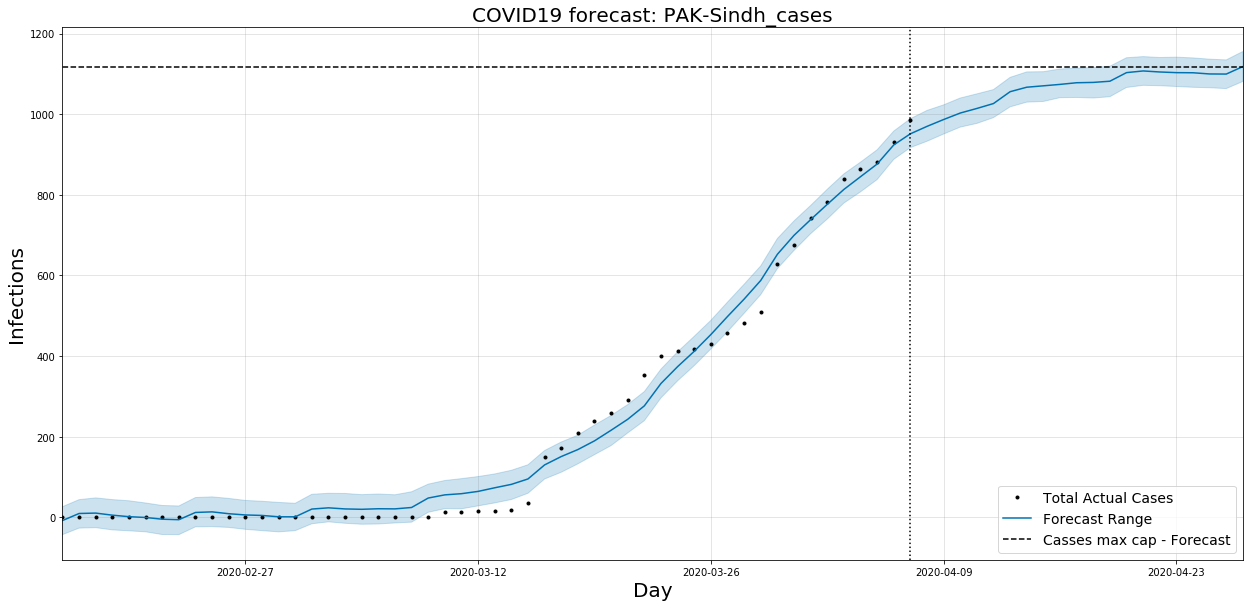

In [38]:
def build_model(country):
    df = pd.read_csv('data/covid19_processed_data_' + country + '.csv', parse_dates=True)
    df_ = df.copy()
    df = df[['Report_Date', country, 'cap']].dropna()
    
    df.columns = ['ds', 'y', 'cap']
    
    m = Prophet(growth="logistic")
    m.fit(df)

    future = m.make_future_dataframe(periods=20)
    future['cap'] = df['cap'].iloc[0]

    forecast = m.predict(future)
    
    res_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds').y).reset_index()
    res_df['current_date'] = df['ds'].iloc[-1]
    res_df['fastest_growth_day'] = df_['fastest_grow_day'].iloc[-1]
    res_df['growth_stabilized'] = df_['growth_stabilized'].iloc[-1]
    res_df['current_day'] = df_['timestep'].iloc[-1]
    res_df['cap'] = df['cap'].iloc[0]
    
    res_df.to_csv('data/covid19_forecast_data_' + country + '.csv')
    
    print('Processed:', country)
    
    fig1 = m.plot(forecast)
    fig1.set_size_inches(18.5, 8.5)
    datenow = datetime(2020, 4, 7)
    dateend = datenow + timedelta(days=20)
    datestart = dateend - timedelta(days=71)
    plt.xlim([datestart, dateend])
    plt.title("COVID19 forecast: " + country, fontsize=20)
    plt.xlabel("Day", fontsize=20)
    plt.ylabel("Infections", fontsize=20)
    plt.axvline(datenow, color="k", linestyle=":")
    plt.legend(["Total Actual Cases","Forecast Range","Casses max cap - Forecast"], loc = 'lower right', fontsize = '14')
    plt.show()

    #print(res_df[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'current_date', 'fastest_growth_day', 'growth_stabilized', 'current_day']].tail(30))

build_model('PAK-Sindh_cases')